In [1001]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [1002]:
data = pd.read_csv("./data.csv")
print(data.head())

train_data = data[data["subject"] == 1]["shape_num"].to_numpy()

print(train_data.shape)


def gen_data(d):
    data = np.empty((0, 24))
    for index in d:
        #print("item?: ", index)
        # Create an array of zeros with length 24
        result_array = np.zeros(24)
        result_array[d[index] - 1] = 1
        data = np.vstack((data, result_array))
    return data

X_train = gen_data(train_data)

print(X_train.shape)
print(X_train[:3])


"""
y train creation:

Hetzelfde maar dus elke keer item van de volgende in de lijst en elke na 3de element is [0,...,0]
"""

y_train = X_train.copy()
y_train[:-1] = X_train[1:]

print(y_train.shape, X_train.shape)
print(X_train[:4])
print("---")
print(y_train[:4])

y_train[2::3] = np.zeros((192, 24))

print(X_train[:4])
print("---")
print(y_train[:4])

X_test = X_train[:24]
y_test = y_train[:24]

#X_train = np.reshape(X_train, (24, -1, 24))
#X_test = np.reshape(X_test, (24, -1, 24))

#X_train = np.reshape(X_train, (-1, 24, 24))
#X_test = np.reshape(X_test, (-1, 24, 24))

X_train = np.reshape(X_train, (-1, 1, 24))
X_test = np.reshape(X_test, (-1, 1,  24))

#y_train = np.reshape(y_train, (24, -1, 24))
#y_test = np.reshape(y_test, (24, -1, 24))

y_train = np.reshape(y_train, (-1, 1, 24))
y_test = np.reshape(y_test, (-1, 1, 24))

#y_train = np.reshape(y_train, (-1, 24, 24))
#y_test = np.reshape(y_test, (-1, 24, 24))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

   subject         ave          sd  block  triplet  position  shape_num    RT  \
0        1  463.309028  298.476633      1        1         1          1  1121   
1        1  463.309028  298.476633      1        1         2          2   886   
2        1  463.309028  298.476633      1        1         3          3   837   
3        1  463.309028  298.476633      1        7         1         19   843   
4        1  463.309028  298.476633      1        7         2         20  1264   

    RT_trimmed  log_RT_trimmed  change?  block>12  block>18  block>6  \
0  1060.262293        6.966272        1     False     False    False   
1   886.000000        6.786717        0     False     False    False   
2   837.000000        6.729824        0     False     False    False   
3   843.000000        6.736967        0     False     False    False   
4  1060.262293        6.966272        1     False     False    False   

   1-avg(2,3)  log_1-avg(2,3) odd_even  
0         NaN             NaN        o 

In [1003]:
def build_network(learning_rate: float = 0.003):
      model = tf.keras.Sequential()
      model.add(tf.keras.Input(shape=(1,24)))
      model.add(tf.keras.layers.SimpleRNN(units=64, return_sequences = True, activation = "tanh"))
      #model.add(tf.keras.layers.GRU(units=64, return_sequences = True, activation = "tanh"))
      #model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=24, activation="softmax")))  # Output shape should match the number of features
      model.add(tf.keras.layers.Dense(units=24, activation = "relu")) 
      loss = tf.keras.losses.CategoricalCrossentropy()
      model.compile(optimizer = \
         tf.keras.optimizers.Adam(learning_rate = learning_rate), loss = loss, metrics = ["accuracy"])	
      return model


In [1004]:
def train_model():
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    res = model.fit(X_train, y_train, epochs = 100, verbose=1)
    return res

In [1005]:
def show_res(res, verbose: bool = False):
    if verbose:
        print(res.history)
    fig, axs = plt.subplots(2,2)
    axs[0, 0].set_title("training loss")
    axs[0, 0].plot(res.history["loss"])
    axs[0, 1].set_title("training accuracy")
    axs[0, 1].plot(res.history["accuracy"])
    axs[1, 0].set_title("test loss")
    #axs[1, 0].plot(res.history["val_loss"])
    axs[1, 1].set_title("test accuracy")
    #axs[1, 1].plot(res.history["val_accuracy"])
    plt.show()

(576, 1, 24) (576, 1, 24) (24, 1, 24) (24, 1, 24)
Epoch 1/100
18/18 [==============================] - 0s 822us/step - loss: 4.0725 - accuracy: 0.2523
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 3.0381 - accuracy: 0.4943
Epoch 3/100
18/18 [==============================] - 0s 857us/step - loss: 3.2378 - accuracy: 0.4415
Epoch 4/100
18/18 [==============================] - 0s 1ms/step - loss: 3.4977 - accuracy: 0.4600
Epoch 5/100
18/18 [==============================] - 0s 1ms/step - loss: 3.2926 - accuracy: 0.4384
Epoch 6/100
18/18 [==============================] - 0s 880us/step - loss: 3.2850 - accuracy: 0.4568
Epoch 7/100
18/18 [==============================] - 0s 728us/step - loss: 3.4087 - accuracy: 0.4519
Epoch 8/100
18/18 [==============================] - 0s 842us/step - loss: 3.3303 - accuracy: 0.4560
Epoch 9/100
18/18 [==============================] - 0s 1ms/step - loss: 3.3912 - accuracy: 0.4495
Epoch 10/100
18/18 [=============================

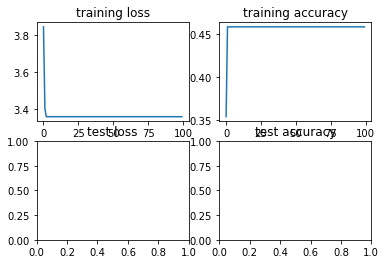

[[[0.         0.         0.71804285 0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.48609546 0.         0.         0.         0.         0.        ]]

 [[0.         0.         0.4451102  0.09778981 0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.16484374 0.         0.         0.         0.
   0.10016628 0.         0.06699137 0.         0.         0.        ]]

 [[0.         0.         0.19389865 0.2121391  0.         0.
   0.14435397 0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.00580905 0.
   0.16718039 0.0493899  0.         0.04769227 0.   

In [1006]:
model = build_network()
res = train_model()
model.summary()

show_res(res)

print(model.predict(X_test))
print(model.predict(X_test).shape)

(24, 1, 24)
(24, 1, 24)
[[0.         0.         0.71804285 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]]
i 0
pred: i,  [0.         0.         0.71804285 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
i 1
pred: i,  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.48609546 0.         0.         0.         0.         0.        ]
i 2
pred: i,  [0.         0.         0.4451102  0.09778981 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.16484374 0.         0.         0.         0.
 0.10016628 0.   

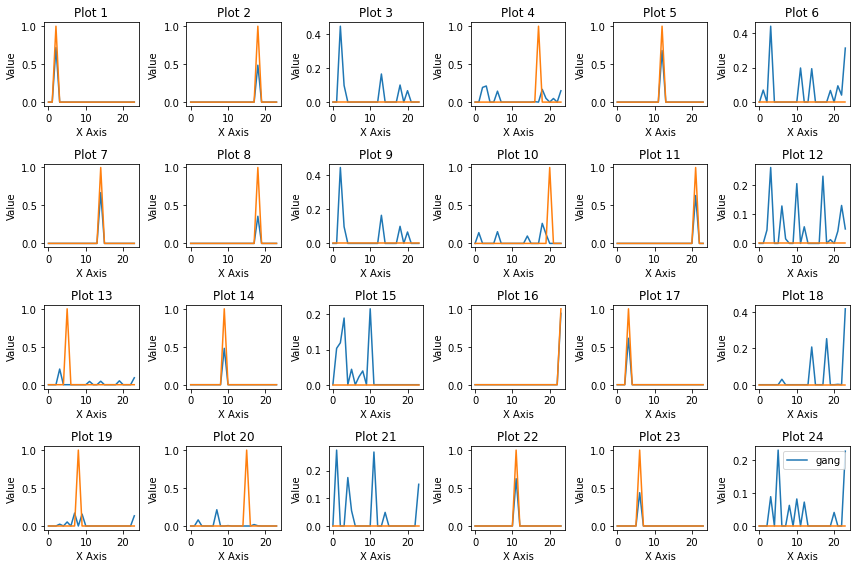

In [1009]:
pred = model.predict(X_test)
print(pred.shape)
print(y_test.shape)

print(pred[0])

# Create 24 subplots
fig, axes = plt.subplots(4, 6, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    print("i", i)
    #ax.plot(pred[i, 0, :])
    ax.plot(pred[i, 0, :], label="gang")
    print("pred: i, ", pred[i][0])
    ax.plot(y_test[i, 0, :])
    #ax.plot(y_test[i])
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Value')
    ax.set_title(f'Plot {i+1}')

plt.tight_layout()
plt.legend()
plt.show()

In [1008]:
# Generate a random 3D array for demonstration
preds = model.predict(X_test)
print(preds.shape)

# Find the index of the maximum value
max_index = np.argmax(preds[0])
print(max_index)

# Create a new array with all zeros and set the maximum value to 1
new_array = np.zeros_like(np.arange(24))
new_array[max_index] = 1

# Print the result
print(new_array.shape)
print(preds[0])
print(new_array)
print(y_test[0])

(24, 1, 24)
2
(24,)
[[0.         0.         0.71804285 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
